On April 15, 1912, during her maiden voyage, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 passengers and crew. Translated 32% survival rate.


Let's analyse which parameters correlate with survivability and make a model to predict the test sample

In [1]:
# data analysis
import pandas as pd
import numpy as np
import random as random

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

### Import data to pandas from a csv file

In [2]:
train_df = pd.read_csv('../input/train.csv')
test_df = pd.read_csv('../input/test.csv')
combine = [train_df, test_df]

Which features are implemented in dataset and what they mean?

In [3]:
print(train_df.columns.values)

['PassengerId' 'Survived' 'Pclass' 'Name' 'Sex' 'Age' 'SibSp' 'Parch'
 'Ticket' 'Fare' 'Cabin' 'Embarked']


['PassengerId' 'Survived' 'Pclass' 'Name' 'Sex' 'Age' 'SibSp' 'Parch'
 'Ticket' 'Fare' 'Cabin' 'Embarked']

In [4]:
# preview the data
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


    Variable	Definition	Key
    survival	Survival	0 = No, 1 = Yes
    pclass	Ticket class	1 = 1st, 2 = 2nd, 3 = 3rd
    sex	Sex	
    Age	Age in years	
    sibsp	# of siblings / spouses aboard the Titanic	
    parch	# of parents / children aboard the Titanic	
    ticket	Ticket number	
    fare	Passenger fare	
    cabin	Cabin number	
    embarked	Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton
    survival	Survival	0 = No, 1 = Yes
    pclass	Ticket class	1 = 1st, 2 = 2nd, 3 = 3rd
    sex	Sex	
    Age	Age in years	
    sibsp	# of siblings / spouses aboard the Titanic	
    parch	# of parents / children aboard the Titanic	
    ticket	Ticket number	
    fare	Passenger fare	
    cabin	Cabin number	
    embarked	Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton

In [5]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Lets make more values numerical by transforming:
    Sex: Male: 0, Female: 1
    Embarked: C: 0, S: 1, Q: 2


In [6]:
for dataset in combine:
    dataset['Sex'] = dataset['Sex'].map( {'female': 1, 'male': 0} ).astype(int)
    

train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,S


In [7]:
train_df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


### Category Embarked contains only two empty values. Let's fill it with the most common one

In [8]:
freq_port = train_df.Embarked.dropna().mode()[0]



In [9]:
for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].fillna(freq_port)
    dataset['Embarked'] = dataset['Embarked'].map( {'C': 0, 'S': 1, 'Q': 2} ).astype(int)
    
train_df[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean().sort_values(by='Survived', ascending=False)



,Embarked,Survived
0,0,0.553571
2,2,0.389610
1,1,0.339009


In [10]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,0
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,1
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,1


### Now lets look at the survivability in terms of age and sex

In [11]:
train_df.groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Sex,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Embarked
1,1,431.028662,0.742038,2.159236,27.915709,0.694268,0.649682,44.479818,0.882166
0,0,454.147314,0.188908,2.389948,30.726645,0.429809,0.235702,25.523893,0.906412


We can see that women have much higher Survived value. Mean value of age for both women and men is quite similar. Let's look at some histograms

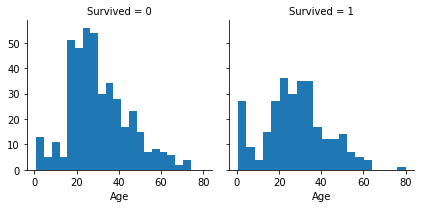

In [12]:
plot = sns.FacetGrid(train_df, col='Survived')
plot.map(plt.hist, 'Age', bins=20)

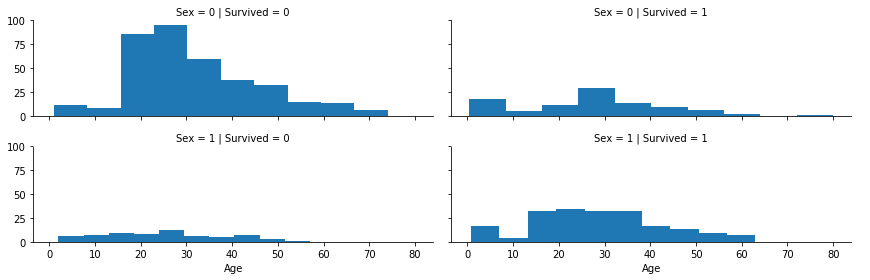

In [13]:
grid = sns.FacetGrid(train_df, col='Survived', row='Sex', height=2, aspect=3)
grid.map(plt.hist, 'Age', bins=10)
grid.add_legend();

We can see that a lot of men in age of 15-30 died 

### And lets check other relations

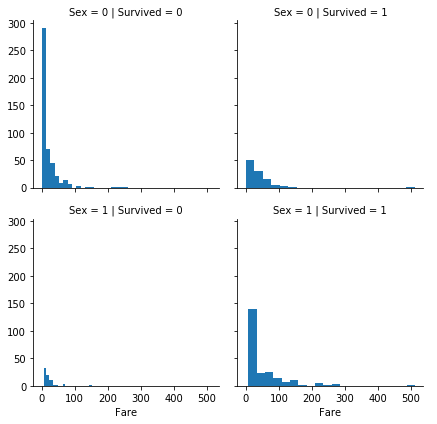

In [14]:
grid = sns.FacetGrid(train_df, col='Survived', row='Sex')
grid.map(plt.hist, 'Fare', bins=20)
grid.add_legend();

In [15]:
#Fill NaN falues with median value
test_df['Fare'].fillna(test_df['Fare'].dropna().median(), inplace=True)

#And create Fare Band
train_df['Band'] = pd.qcut(train_df['Fare'], 4)
train_df[['Band', 'Survived']].groupby(['Band'], as_index=False).mean().sort_values(by='Band', ascending=True) 


    


,Band,Survived
0,"(-0.001, 7.91]",0.197309
1,"(7.91, 14.454]",0.303571
2,"(14.454, 31.0]",0.454955
3,"(31.0, 512.329]",0.581081


In [16]:
#Insert values
for dataset in combine:
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)

train_df = train_df.drop(['Band'], axis=1)
combine = [train_df, test_df]

In [17]:
train_df[['Fare', 'Survived']].groupby(['Fare'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Fare,Survived
3,3,0.581081
2,2,0.445415
1,1,0.308756
0,0,0.197309


### Higher Fare contributes to survivability

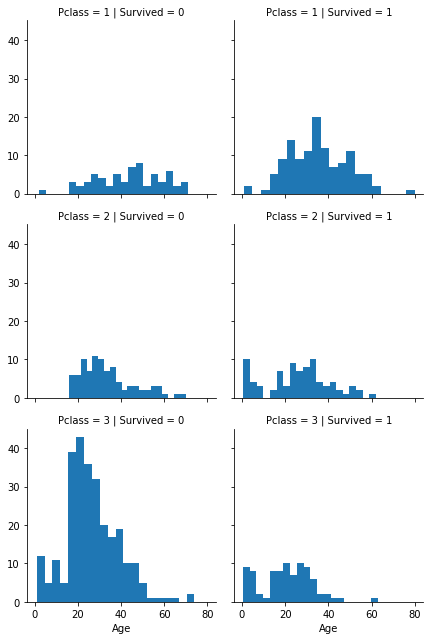

In [18]:
grid = sns.FacetGrid(train_df, col='Survived', row='Pclass')
grid.map(plt.hist, 'Age', bins=20)
grid.add_legend();

In [19]:
train_df[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


    We can also create a band in tearms of Age.
    But at frst we have to predict the empty values
    Let's predict it using Sex and Pclass data

In [20]:
#create an empty array to store values
guess_ages = np.zeros((2,3))



In [21]:

for dataset in combine:
    for i in range(0, 2):
        for j in range(0, 3):
            #store the diffrent Age values
            guess_df = dataset[(dataset['Sex'] == i) & \
                                  (dataset['Pclass'] == j+1)]['Age'].dropna()

            # use the median to guess the age
            age_guess = guess_df.median()

            #store it in array
            guess_ages[i,j] = int( age_guess)            
    


In [22]:
for dataset in combine:
    
# Now, fill the empty values with predicted data
    for i in range(0, 2):
        for j in range(0, 3):
            dataset.loc[ (dataset.Age.isnull()) & (dataset.Sex == i) & (dataset.Pclass == j+1),\
                        'Age'] = guess_ages[i,j]

    dataset['Age'] = dataset['Age'].astype(int)

train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",0,22,1,0,A/5 21171,0,NaN,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38,1,0,PC 17599,3,C85,0
2,3,1,3,"Heikkinen, Miss. Laina",1,26,0,0,STON/O2. 3101282,1,NaN,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35,1,0,113803,3,C123,1
4,5,0,3,"Allen, Mr. William Henry",0,35,0,0,373450,1,NaN,1


In [23]:
#create band
train_df['Band'] = pd.cut(train_df['Age'], 6)
train_df[['Band', 'Survived']].groupby(['Band'], as_index=False).mean().sort_values(by='Band', ascending=True)




,Band,Survived
0,"(-0.08, 13.333]",0.591549
1,"(13.333, 26.667]",0.321244
2,"(26.667, 40.0]",0.417969
3,"(40.0, 53.333]",0.414062
4,"(53.333, 66.667]",0.348837
5,"(66.667, 80.0]",0.142857


In [24]:
# replace values in range of band
for dataset in combine:    
    dataset.loc[ dataset['Age'] <= 13.333, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 13.333) & (dataset['Age'] <= 26.667), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 26.667) & (dataset['Age'] <= 40), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 40) & (dataset['Age'] <= 53.333), 'Age'] = 3
    dataset.loc[(dataset['Age'] > 53.333) & (dataset['Age'] <= 66.667), 'Age'] = 4
    dataset.loc[ dataset['Age'] > 66.667, 'Age'] =5
train_df[['Age', 'Survived']].groupby(['Age'], as_index=False).mean().sort_values(by='Age', ascending=True)





,Age,Survived
0,0,0.591549
1,1,0.321244
2,2,0.417969
3,3,0.414062
4,4,0.348837
5,5,0.142857


In [25]:
train_df = train_df.drop(['Band'], axis=1)
combine = [train_df, test_df]
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",0,1,1,0,A/5 21171,0,NaN,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,2,1,0,PC 17599,3,C85,0
2,3,1,3,"Heikkinen, Miss. Laina",1,1,0,0,STON/O2. 3101282,1,NaN,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,2,1,0,113803,3,C123,1
4,5,0,3,"Allen, Mr. William Henry",0,2,0,0,373450,1,NaN,1


/opt/conda/lib/python3.6/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/opt/conda/lib/python3.6/site-packages/seaborn/axisgrid.py:720: UserWarning: Using the pointplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


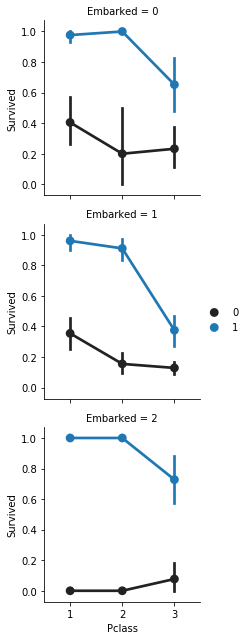

In [26]:
grid = sns.FacetGrid(train_df, row='Embarked')
grid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex')
grid.add_legend()

/opt/conda/lib/python3.6/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


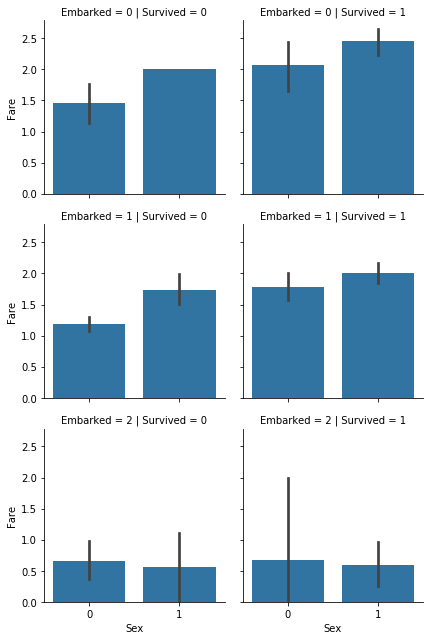

In [27]:

grid = sns.FacetGrid(train_df, row='Embarked', col='Survived')
grid.map(sns.barplot, 'Sex', 'Fare')
grid.add_legend()

People with 1st and 2nd class ticket had higher chance of survivability than those from 3rd class.
And also we see that Embarked point contributes to survavibility

Also lets make a new feature from existing ones. Let's add siblings / spouses aboard the Titanic    
and parents / children aboard the Titanic to check if there is any correlation between family size and Survivability

In [28]:
for dataset in combine:
    dataset['FamilyCount'] = dataset['SibSp'] + dataset['Parch'] + 1

train_df[['FamilyCount', 'Survived']].groupby(['FamilyCount'], as_index=False).mean().sort_values(by='FamilyCount', ascending=True)

,FamilyCount,Survived
0,1,0.303538
1,2,0.552795
2,3,0.578431
3,4,0.724138
4,5,0.200000
5,6,0.136364
6,7,0.333333
7,8,0.000000
8,11,0.000000


    We can save it as another paameter: 
    Alone: is alone: 1, is not alone: 0

In [29]:
for dataset in combine:
    dataset['Alone'] = 0
    #Lets set a default value as 0
    dataset.loc[dataset['FamilyCount'] == 1, 'Alone'] = 1 
    # If that person had only 1 family member it means he/she was alone

train_df[['Alone', 'Survived']].groupby(['Alone'], as_index=False).mean()

,Alone,Survived
0,0,0.505650
1,1,0.303538


Now, after constructing new feature we can drop those which we won't use

In [30]:
print(train_df.columns.values)

['PassengerId' 'Survived' 'Pclass' 'Name' 'Sex' 'Age' 'SibSp' 'Parch'
 'Ticket' 'Fare' 'Cabin' 'Embarked' 'FamilyCount' 'Alone']


['PassengerId' 'Survived' 'Pclass' 'Name' 'Sex' 'Age' 'SibSp' 'Parch'
 'Ticket' 'Fare' 'Cabin' 'Embarked' 'FamilyCount' 'Alone']

In [31]:
train_df.describe(include=['O'])

,Name,Ticket,Cabin
count,891,891,204
unique,891,681,147
top,"Hart, Mrs. Benjamin (Esther Ada Bloomfield)",CA. 2343,B96 B98
freq,1,7,4


Now we can drop columns like: PassengerId, Name, SibSp, Parch, Ticket, Cabin, FamilCount.
It makes analysys easier and faster

1. Name feature is unique.
2. Ticket feature, there may not be a correlation between Ticket and survival.
3. Cabin feature may be dropped becouse it is highly incomplete or contains many null values.
4. PassengerId does not contribute to survival.
 



In [32]:
train_df = train_df.drop([ 'PassengerId','Name','SibSp','Parch','Ticket','Cabin','FamilyCount',], axis=1)
test_df = test_df.drop([ 'PassengerId','Name','SibSp','Parch','Ticket','Cabin','FamilyCount',], axis=1)
combine = [train_df, test_df]


In [33]:
print(train_df.columns.values)

['Survived' 'Pclass' 'Sex' 'Age' 'Fare' 'Embarked' 'Alone']


['Survived' 'Pclass' 'Sex' 'Age' 'Fare' 'Embarked' 'Alone']

## Create model, learn and predict



The problem is a classification and regression problem. I want to identify relationship between output (Survived or not) with other variables or features. This type of machine learning called supervised learning as we are training our model with a given dataset. 

- Logistic Regression
- Random Forrest







In [34]:
X_train = train_df.drop("Survived", axis=1)
Y_train = train_df["Survived"]
X_test  = test_df.copy()

#X_train.shape, Y_train.shape, X_test.shape

## Logistic Regression 

In [35]:
logreg = LogisticRegression()
logreg.fit(X_train, Y_train)
Y_pred = logreg.predict(X_test)



/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)



- Sex is highest positivie coefficient, implying as the Sex value increases (male: 0 to female: 1), the probability of Survived=1 increases the most.
- Inversely as Pclass increases, probability of Survived=1 decreases the most.

In [36]:
coeff_df = pd.DataFrame(train_df.columns.delete(0))
coeff_df.columns = ['Feature']
coeff_df["Correlation"] = pd.Series(logreg.coef_[0])

coeff_df.sort_values(by='Correlation', ascending=False)

,Feature,Correlation
1,Sex,2.540746
5,Alone,0.150003
3,Fare,0.055180
4,Embarked,-0.153310
2,Age,-0.404879
0,Pclass,-1.095362


Random forests is learning method for classification and regression.

In [37]:
# Random Forest

random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, Y_train)
Y_pred = random_forest.predict(X_test)
random_forest.score(X_train, Y_train)
round(random_forest.score(X_train, Y_train) * 100, 2)


86.98

In [38]:
print(f"Regression score: {round(logreg.score(X_train, Y_train) * 100, 2)}",f"Random Forest score:{round(random_forest.score(X_train, Y_train) * 100, 2)}")

Regression score: 80.13 Random Forest score:86.98


Random forest model gives better results